# (Dataset Exploration Title)
## by (your name here)

## Preliminary Wrangling

> Briefly introduce your dataset here.

In [44]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import zipfile
import glob
import os
import math
import requests
import io

%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [50]:
raw_data = "raw_data"

fordgobike = "fordgobike"
baywheels = "baywheels"
# The placeholders should have year, month and then provider.
# Provider changed from ford gobike to baywheels from 2019 May.
baseUrl = "https://s3.amazonaws.com/baywheels-data/{}{}-{}-tripdata.csv.zip"

In [52]:
def download_and_extract_file(url: str, targetDir: str = raw_data):
    print("fetching {}".format(url))
    r = requests.get(url)
    if r.status_code != 200:
        print("error fetching {} : {}".format(url, r.reason))
        return
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(targetDir)

url_2017 = baseUrl.format("2017", "", fordgobike)
download_and_extract_file(url_2017)

current_year = 2020
current_month = 1

for year in range(2018, current_year):
    for month in range(1, 13):
        provider = fordgobike
        if year >= 2019 and month >= 5:
            provider = baywheels
        url = baseUrl.format(year, "{:02d}".format(month), provider)
        download_and_extract_file(url)

for month in range(1, current_month + 1):
    url = baseUrl.format(current_year, "{:02d}".format(month), baywheels)
    download_and_extract_file(url)

fetching https://s3.amazonaws.com/baywheels-data/2017-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201801-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201802-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201803-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201804-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201805-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201806-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201807-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201808-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201809-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201810-fordgobike-tripdata.csv.zip
fetching https://s3.amazonaws.com/baywheels-data/201811-fordgobike-tripdata.cs

In [53]:
# Read all csv files in the data directory.
all_files = glob.glob(os.path.join(raw_data, "*.csv"))

# Explictly mention column data types to suppress low memory warnings caused by pandas guessing the dtype.
# See https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options
dtypes={'user_type': str, 'bike_share_for_all_trip': str, 'rental_access_method': str}

# Pass sort=False to concat method to adhere to future behavior and suppress deperecation warnings
# See https://stackoverflow.com/questions/50501787/python-pandas-user-warning-sorting-because-non-concatenation-axis-is-not-aligne
raw_df = pd.concat((pd.read_csv(f, dtype=dtypes) for f in all_files), ignore_index = True, sort=False)

In [54]:
raw_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 15 columns):
duration_sec               5186258 non-null int64
start_time                 5186258 non-null object
end_time                   5186258 non-null object
start_station_id           4944185 non-null float64
start_station_name         4945366 non-null object
start_station_latitude     5186258 non-null float64
start_station_longitude    5186258 non-null float64
end_station_id             4941665 non-null float64
end_station_name           4942794 non-null object
end_station_latitude       5186258 non-null float64
end_station_longitude      5186258 non-null float64
bike_id                    5186258 non-null int64
user_type                  5186258 non-null object
bike_share_for_all_trip    4359974 non-null object
rental_access_method       306584 non-null object
dtypes: float64(6), int64(2), object(7)
memory usage: 593.5+ MB


### What is the structure of your dataset?

> Your answer here!

### What is/are the main feature(s) of interest in your dataset?

> Your answer here!

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Your answer here!

In [55]:
raw_df.isnull().sum()

duration_sec                     0
start_time                       0
end_time                         0
start_station_id            242073
start_station_name          240892
start_station_latitude           0
start_station_longitude          0
end_station_id              244593
end_station_name            243464
end_station_latitude             0
end_station_longitude            0
bike_id                          0
user_type                        0
bike_share_for_all_trip     826284
rental_access_method       4879674
dtype: int64

In [ ]:
df.duration_sec.max()

### Cleaning 

Following cleaning operations can be performed on this dataset

#### Quality Issues
1. We can choose to make `bike_id`, `start_station_id`, and `end_station_id` as object type instead of numerical types.
2. We can format the `start_time` and `end_time` as datetime format.
3. `user_type`, `rental_access_method` and `bike_share_for_all_trip` can be marked as categorical data types.
4. We can drop the rows where `start_station_id`, `start_station_name`, `end_station_id`, and `end_station_name` are null but since none of these are critical for analysis we can retain the rows with missing values.

#### Tidy up
1. Instead of having a `duration_sec` column, we can round up the seconds to create a `duration_min` column. This is also more accurate since GoBike platform bills the users by number of minutes used.
2. This is not exactly tidying up but we can introduce new columns for year, month, weekday, and hour by parsing the `start_time` as these can be used in analysis.

In [56]:
# Copy the dataframe for checkpointing
df = raw_df.copy()

##### Mark `bike_id`, `start_station_id`, and `end_station_id` as object type

In [57]:
# Code
df.bike_id = df.bike_id.astype(object)
df.start_station_id = df.start_station_id.astype(object)
df.end_station_id = df.end_station_id.astype(object)

# Test 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 15 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
bike_share_for_all_trip    object
rental_access_method       object
dtypes: float64(4), int64(1), object(10)
memory usage: 593.5+ MB


##### Format `start_time` and `end_time` as datetime

In [58]:
# Code
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

# Test
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 15 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
bike_share_for_all_trip    object
rental_access_method       object
dtypes: datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 593.5+ MB


##### Mark `user_type`, `rental_access_method` and `bike_share_for_all_trip` as categorical data types

In [59]:
# Code
df.user_type = df.user_type.astype("category")
df.rental_access_method = df.rental_access_method.astype("category")
df.bike_share_for_all_trip = df.bike_share_for_all_trip.astype("category")

# Test
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 15 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  category
bike_share_for_all_trip    category
rental_access_method       category
dtypes: category(3), datetime64[ns](2), float64(4), int64(1), object(5)
memory usage: 489.7+ MB


#### Tidying up

##### Add a `duration_min` column from `duration_sec` column

In [60]:
# Code
df['duration_min'] = df.duration_sec.map(lambda x: math.ceil(x/60))

# Test
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  category
bike_share_for_all_trip    category
rental_access_method       category
duration_min               int64
dtypes: category(3), datetime64[ns](2), float64(4), int64(2), object(5)
memory usage: 529.2+ MB


##### Add `year`, `month`, and `weekday` columns for each ride

In [61]:
# See https://strftime.org/ for formatting reference
df['ride_year'] = df.start_time.map(lambda x: x.strftime('%Y'))
df['ride_month'] = df.start_time.map(lambda x: x.strftime('%b'))
df['ride_weekday'] = df.start_time.map(lambda x: x.strftime('%a'))
df['ride_hour'] = df.start_time.map(lambda x: x.strftime('%H'))

In [62]:
# Mark month and weekday as category variable
df.ride_year = df.ride_year.astype('category')
df.ride_month = df.ride_month.astype('category')
df.ride_weekday = df.ride_weekday.astype('category')
df.ride_hour = df.ride_hour.astype('category')

# Test
print(df.ride_year.unique())
print(df.ride_month.unique())
print(df.ride_weekday.unique())
print(df.ride_hour.unique())

df.info()

[2019, 2018, 2017, 2020]
Categories (4, object): [2019, 2018, 2017, 2020]
[Dec, Apr, Nov, Jan, Oct, ..., Sep, Aug, Mar, Feb, May]
Length: 12
Categories (12, object): [Dec, Apr, Nov, Jan, ..., Aug, Mar, Feb, May]
[Tue, Mon, Sun, Sat, Fri, Thu, Wed]
Categories (7, object): [Tue, Mon, Sun, Sat, Fri, Thu, Wed]
[14, 21, 23, 22, 20, ..., 06, 05, 03, 04, 02]
Length: 24
Categories (24, object): [14, 21, 23, 22, ..., 05, 03, 04, 02]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186258 entries, 0 to 5186257
Data columns (total 20 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  categ

In [63]:
df.ride_year.value_counts()

2019    2506983
2018    1863721
2017     519700
2020     295854
Name: ride_year, dtype: int64

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

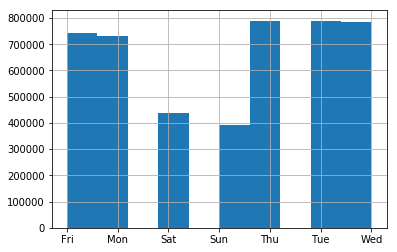

In [18]:
df.ride_weekday.hist()

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!